# Set Up/Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# conda activate "/pscratch/sd/m/mansisak/memorization/env/"

In [3]:
# !pip list

In [4]:
#pip install accelerate

In [5]:
import torch
import os
from transformers import AutoModelForCausalLM
from torch.utils.data import DataLoader
from tqdm import tqdm

### TODO: figure out automatically
# device = "cpu"
device = "cuda"

/global/cfs/cdirs/m636/geniesse/envs/memorization/lib/python3.10/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


# Load in Models

In [6]:
def print_edited_model_paths(parent_path):
    
    total_exp = 0
    for model_name in ['pythia-6.9b-deduped', 'pythia-2.8b-deduped']:
        y_idx = 0
        for step in [36000, 72000, 108000, 143000]:
            for loc_method in [
                  "act",
                  "hc",
                  "slim",
                  "durable",
                  "durable_agg",
                  "random",
                  "random_greedy",
                  "greedy",
              ]:
                
                for ratio in [0.00001, 0.0001, 0.001, 0.01, 0.05, 0.1, 0.25, 0.3]:
                    result_path = f"{parent_path}{step}/EleutherAI_edit/{loc_method}/mem/{ratio}"
                    if loc_method not in ["random", "random_greedy"]:
                        if ratio >= 0.1:
                            continue

                    # this ratio is too small for neuron-level methods
                    if loc_method in ["zero", "hc", "ig", "slim", "act"]:
                        if ratio <= 0.0001:
                            continue

                    if loc_method in ["greedy"]:
                        if ratio > 0.00001:
                            continue
                            
                    ######
                    if loc_method in ["greedy", "durable", "durable_agg","act"]:
                        model_path = f'{result_path}/{model_name}'
                        total_exp += 1

                    if loc_method in ["slim", "hc"]:
                        for epochs in [1, 10, 20]:
                            total_exp += 1
                            model_path = f'{result_path}/{epochs}/1000/0.1/0.1/{model_name}'                      

                    if loc_method in ["random", "random_greedy"]:
                        for epochs in [1, 10, 20]:
                            total_exp += 1
                            model_path = f'{result_path}/{epochs}/0.1/0.9/0.0005/{model_name}'
                    if os.path.isfile(model_path):
                        print("edited model exists:", model_path)
                    else:
                        print("edited model doesn't exist yet: ", model_path)

    print("total_expeirments: ", total_exp)



In [7]:
# parent_path = "/pscratch/sd/m/mansisak/memorization/model_ckpts/"
parent_path = "/pscratch/sd/m/mansisak/memorization/model_ckpts/old_run/"

print_edited_model_paths(parent_path)

edited model doesn't exist yet:  /pscratch/sd/m/mansisak/memorization/model_ckpts/old_run/36000/EleutherAI_edit/act/mem/0.001/pythia-6.9b-deduped
edited model doesn't exist yet:  /pscratch/sd/m/mansisak/memorization/model_ckpts/old_run/36000/EleutherAI_edit/act/mem/0.01/pythia-6.9b-deduped
edited model doesn't exist yet:  /pscratch/sd/m/mansisak/memorization/model_ckpts/old_run/36000/EleutherAI_edit/act/mem/0.05/pythia-6.9b-deduped
edited model doesn't exist yet:  /pscratch/sd/m/mansisak/memorization/model_ckpts/old_run/36000/EleutherAI_edit/hc/mem/0.001/20/1000/0.1/0.1/pythia-6.9b-deduped
edited model doesn't exist yet:  /pscratch/sd/m/mansisak/memorization/model_ckpts/old_run/36000/EleutherAI_edit/hc/mem/0.01/20/1000/0.1/0.1/pythia-6.9b-deduped
edited model doesn't exist yet:  /pscratch/sd/m/mansisak/memorization/model_ckpts/old_run/36000/EleutherAI_edit/hc/mem/0.05/20/1000/0.1/0.1/pythia-6.9b-deduped
edited model doesn't exist yet:  /pscratch/sd/m/mansisak/memorization/model_ckpts/o

In [8]:
# Example of how to load in a model:

model = AutoModelForCausalLM.from_pretrained(
    "EleutherAI/pythia-2.8b-deduped",
    torch_dtype=torch.float16,
    device_map=device
)

# sd_path = '/pscratch/sd/m/mansisak/memorization/model_ckpts/old_run/143000/EleutherAI_edit/random_greedy/mem/0.001/20/0.1/0.9/0.0005/pythia-2.8b-deduped'
sd_paths = dict(
    unedited = None,
    good_edit = "/pscratch/sd/m/mansisak/memorization/model_ckpts/old_run/143000/EleutherAI_edit/random_greedy/mem/0.001/20/0.1/0.9/0.0005/pythia-2.8b-deduped",
    bad_edit = "/pscratch/sd/m/mansisak/memorization/model_ckpts/old_run/143000/EleutherAI_edit/random/mem/0.1/20/0.1/0.9/0.0005/pythia-2.8b-deduped",
)

# choose which model to load
use_model = "unedited" #_edit"
sd_path = sd_paths.get(use_model)

if sd_path is not None:
    sd = torch.load(sd_path, map_location=device)["model_state_dict"]
    if "random" in sd_path:
        for k in sd:
            if "4h" in k:
                #rint(sd[k].shape)
                #rint(k)
                sd[k] = sd[k].T
    model.load_state_dict(sd, assign=True)
model.eval()

GPTNeoXForCausalLM(
  (gpt_neox): GPTNeoXModel(
    (embed_in): Embedding(50304, 2560)
    (emb_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-31): 32 x GPTNeoXLayer(
        (input_layernorm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        (post_attention_dropout): Dropout(p=0.0, inplace=False)
        (post_mlp_dropout): Dropout(p=0.0, inplace=False)
        (attention): GPTNeoXAttention(
          (rotary_emb): GPTNeoXRotaryEmbedding()
          (query_key_value): Linear(in_features=2560, out_features=7680, bias=True)
          (dense): Linear(in_features=2560, out_features=2560, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp): GPTNeoXMLP(
          (dense_h_to_4h): Linear(in_features=2560, out_features=10240, bias=True)
          (dense_4h_to_h): Linear(in_features=10240, out_features=2560, bias=True)


In [9]:
model.device

device(type='cuda', index=0)

# Load memorized data

In [10]:
import copy 

# Get data
if "2" in model.name_or_path:
    data_path = (
        "/pscratch/sd/m/mansisak/memorization/src/data/pythia_mem_data/pythia-2.8b-deduped-v0/pile_bs0-100-dedup.pt"
    )
if "6" in model.name_or_path:
    data_path = "/pscratch/sd/m/mansisak/memorization/src/data/pythia_mem_data/pythia-6.9b-deduped/pile_bs0-100-dedup.pt"
# model_path = f"../../model_ckpts/{args.step}/{args.model_name}"
# print("Model path: ", args.model_path)

data = torch.load(data_path).to(device)
unlearn_set = copy.deepcopy(data)
random_data = torch.load("/pscratch/sd/m/mansisak/memorization/src/data/pythia_mem_data/pile_random_batch.pt").to(device)
random_data_pile = torch.reshape(random_data[0:2040], (3264, 80))
random_data = random_data_pile[0:1632]
extra_data = random_data_pile[1632:]
random_dataloader = DataLoader(random_data, batch_size=32, shuffle=False)

from transformers import AutoModelForCausalLM, AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model.name_or_path)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [11]:
def check_percent_memorized(
    dataset,
    random_dataloader,
    prompt_len,
    k,
    batch_size,
    model,
    max_ctx=650,
    pad_token_id=13,
):
    print("checking perc mem")
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    memorized = 0
    non_memorized = 0
    total = 0
    mem_seq = []
    clean_mem_seq = []
    with torch.inference_mode():
        for batch in tqdm(dataloader):
            outputs = model.generate(
                inputs=batch[:, :prompt_len],  # grab first prompt_len tokens
                attention_mask=torch.ones_like(batch[:, :prompt_len]),
                max_length=max_ctx,
                min_length=max_ctx,
                pad_token_id=pad_token_id,
            )

            # now check if there is a match
            equals = torch.eq(
                outputs[:, prompt_len : prompt_len + k],
                batch[:, prompt_len : prompt_len + k],
            )

            match_rows = equals.all(dim=1)
            total_matchs = match_rows.sum()
            if total_matchs != 0:
                idxs = torch.squeeze(match_rows.nonzero())
                # if there is only one dim, expand dim to match batched idxs
                if idxs.dim() < 1:
                    idxs = torch.unsqueeze(idxs, 0)
                mem_seq.append(batch[idxs])

            total += batch.shape[0]
            memorized += total_matchs
            percent_mem = (memorized / total).item()
            # print("perc mem so far: ", percent_mem)
    # check if list is empty
    if len(mem_seq) > 0:
        mem_seq = torch.cat(mem_seq, 0)
    print("perc mem: ", percent_mem)

    # perplexity_random_batch = perplexity(random_dataloader, model)
    # print("perplexities of random pile batch: ", perplexity_random_batch)

    return percent_mem, mem_seq #, perplexity_random_batch



In [12]:
percent_mem, mem_seq = check_percent_memorized(
                dataset=unlearn_set,
                random_dataloader=random_dataloader,
                prompt_len=32,
                k=40,
                batch_size=64,
                model=model,
                max_ctx=80,
                pad_token_id=tokenizer.eos_token_id,
            )

checking perc mem


100%|██████████| 8/8 [00:16<00:00,  2.00s/it]


perc mem:  0.5346534848213196


In [13]:
mem_dataloader = DataLoader(mem_seq[:10], batch_size=1, shuffle=False)

In [ ]:
mem_seq

# Load random data 

In [14]:
# random_data = torch.load("/pscratch/sd/m/mansisak/memorization/src/data/pythia_mem_data/pile_random_batch.pt")
# random_data_pile = torch.reshape(random_data[0:2040], (3264, 80)).to(device)

# random_data = random_data_pile[0:1632]
# extra_data = random_data_pile[1632:]

random_data = random_data_pile[0:10] # for testing purposes
random_dataloader = DataLoader(random_data, batch_size=1, shuffle=False)

In [ ]:
# # need (inputs, targets) format for PyHessian
# hessian_dataloader = DataLoader([*zip(random_data, random_data)], batch_size=1, shuffle=False)
# hessian_dataloader

# Model Inference

In [15]:
def perplexity(model, dataloader):
    avg_metric = 0
    for i, batch in enumerate(dataloader):
        with torch.no_grad():
            model_output = model(batch, labels=batch)
        loss = model_output.loss
        loss_exp = torch.exp(loss)
        if torch.isinf(loss_exp):
            print(f"Skipping invalid loss...")
            print(f"    {i=}, loss={loss.item()}, exp(loss)={torch.exp(loss).item()}")
        avg_metric += loss_exp
        # print(loss.item())
    return avg_metric / len(dataloader)


def perplexity_criterion(model_output, targets=None):
    loss = model_output.loss
    return torch.exp(loss)


def average_loss(model, dataloader):
    avg_metric = 0
    for i, batch in enumerate(dataloader):
        with torch.no_grad():
            model_output = model(batch, labels=batch)
        loss = model_output.loss
        avg_metric += loss
        # print(loss.item())
    return avg_metric / len(dataloader)


from torch.nn import CrossEntropyLoss
def loss_criterion(model_output, inputs):
    # Shift so that tokens < n predict n
    shift_labels = inputs[..., 1:].contiguous()
    shift_logits = model_output.logits[..., :-1, :].contiguous()
    # Calculate per-token loss
    loss_fct = CrossEntropyLoss(reduction="none")
    loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
    # Resize and average loss per sample
    loss_per_sample = loss.view(shift_logits.size(0), shift_logits.size(1)).mean(axis=1)
    return (loss_per_sample).mean()


In [ ]:
average_loss(model, random_dataloader)

In [ ]:
average_loss(model, mem_dataloader)

In [ ]:
loss_criterion(model(random_data[[1]]), random_data[[1]])

In [ ]:
loss_criterion(model(mem_seq[[1]]), mem_seq[[1]])

# Loss Landscape stuff

In [16]:
import numpy as np
from pyhessian import hessian
from pyhessian.utils import normalization
import copy

import matplotlib.pyplot as plt

In [17]:
def get_params(model_orig, model_perb, direction, alpha):
    for m_orig, m_perb, d in zip(
        model_orig.parameters(), model_perb.parameters(), direction
    ):
        m_perb.data = m_orig.data + alpha * d
    return model_perb

In [18]:
# move model to the CPU
model = model.to("cpu")

In [19]:
model.device

device(type='cpu')

## 1D random directions

Perturbing model...
Evaluating loss...
    (data_index=0, lam=-0.005) loss=4.81640625
Perturbing model...
Evaluating loss...
    (data_index=0, lam=-0.0045) loss=3.951171875
Perturbing model...
Evaluating loss...
    (data_index=0, lam=-0.004) loss=3.1953125
Perturbing model...
Evaluating loss...
    (data_index=0, lam=-0.0035) loss=2.48828125
Perturbing model...
Evaluating loss...
    (data_index=0, lam=-0.003) loss=1.7919921875
Perturbing model...
Evaluating loss...
    (data_index=0, lam=-0.0025) loss=1.2646484375
Perturbing model...
Evaluating loss...
    (data_index=0, lam=-0.002) loss=0.923828125
Perturbing model...
Evaluating loss...
    (data_index=0, lam=-0.0015) loss=0.69970703125
Perturbing model...
Evaluating loss...
    (data_index=0, lam=-0.001) loss=0.61962890625
Perturbing model...
Evaluating loss...
    (data_index=0, lam=-0.0005) loss=0.5986328125
Perturbing model...
Evaluating loss...
    (data_index=0, lam=0.0) loss=0.59912109375
Perturbing model...
Evaluating loss.

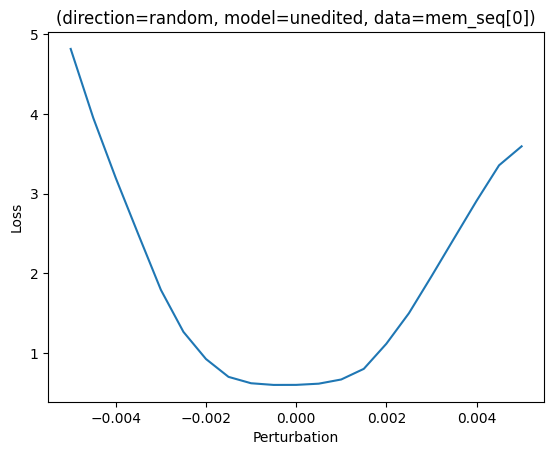

In [32]:
# generate random vector to do the loss plot

### TODO: why does normalization make the direction all zeros ...
v = [torch.randn_like(p) for p in model.parameters()]
# v = normalization(v)

# used to perturb your model 
lams = np.linspace(-0.005, 0.005, 21).astype(np.float32)

for data_index in range(1):

    # create a copy of the model
    with torch.no_grad():
        model_perb = copy.deepcopy(model)
        model_perb.eval()
        # model_perb = model_perb.cuda()

    # store loss values
    loss_list = []

    # loop over grid points
    for lam in lams: 
        
            print("Perturbing model...")
            with torch.no_grad():
                model_perb = model_perb.to("cpu")
                model_perb = get_params(model, model_perb, v, lam)

            print("Evaluating loss...")
            with torch.no_grad():
                model_perb = model_perb.to("cuda")
                loss = loss_criterion(model_perb(mem_seq[[data_index]].to("cuda")), mem_seq[[data_index]].to("cuda")).item()
                loss_list.append(loss)
                print(f"    ({data_index=}, {lam=}) {loss=}")
        

    plt.plot(lams, loss_list)
    plt.ylabel('Loss')
    plt.xlabel('Perturbation')
    plt.title(f'(direction=random, model={use_model}, data=mem_seq[{data_index}])')
    plt.show()

Perturbing model...
Evaluating loss...
    (data_index=0, lam=-0.001) loss=3.099609375
Perturbing model...
Evaluating loss...
    (data_index=0, lam=-0.0009) loss=3.091796875
Perturbing model...
Evaluating loss...
    (data_index=0, lam=-0.0008) loss=3.08984375
Perturbing model...
Evaluating loss...
    (data_index=0, lam=-0.0007) loss=3.08984375
Perturbing model...
Evaluating loss...
    (data_index=0, lam=-0.0006) loss=3.0859375
Perturbing model...
Evaluating loss...
    (data_index=0, lam=-0.0005) loss=3.087890625
Perturbing model...
Evaluating loss...
    (data_index=0, lam=-0.0004) loss=3.083984375
Perturbing model...
Evaluating loss...
    (data_index=0, lam=-0.0003) loss=3.087890625
Perturbing model...
Evaluating loss...
    (data_index=0, lam=-0.0002) loss=3.087890625
Perturbing model...
Evaluating loss...
    (data_index=0, lam=-1e-04) loss=3.0859375
Perturbing model...
Evaluating loss...
    (data_index=0, lam=0.0) loss=3.08984375
Perturbing model...
Evaluating loss...
    (d

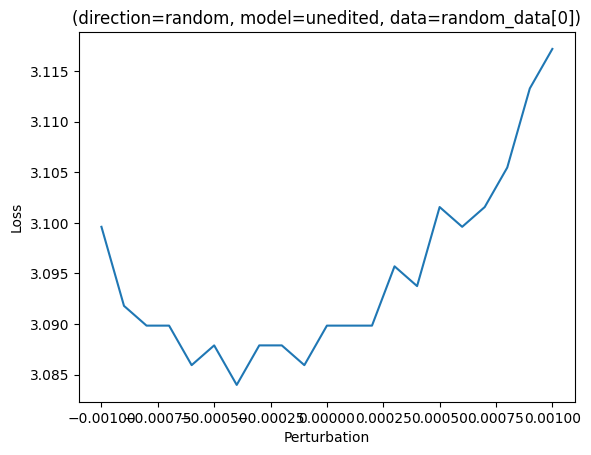

In [33]:
# generate random vector to do the loss plot

### TODO: why does normalization make the direction all zeros ...
v = [torch.randn_like(p) for p in model.parameters()]
# v = normalization(v)

# used to perturb your model 
lams = np.linspace(-0.001, 0.001, 21).astype(np.float32)

for data_index in range(1):

    # create a copy of the model
    with torch.no_grad():
        model_perb = copy.deepcopy(model)
        model_perb.eval()
        # model_perb = model_perb.cuda()

    # store loss values
    loss_list = []

    # loop over grid points
    for lam in lams: 
        
            print("Perturbing model...")
            with torch.no_grad():
                model_perb = model_perb.to("cpu")
                model_perb = get_params(model, model_perb, v, lam)

            print("Evaluating loss...")
            with torch.no_grad():
                model_perb = model_perb.to("cuda")
                loss = loss_criterion(model_perb(random_data[[data_index]].to("cuda")), random_data[[data_index]].to("cuda")).item()
                loss_list.append(loss)
                print(f"    ({data_index=}, {lam=}) {loss=}")
        

    plt.plot(lams, loss_list)
    plt.ylabel('Loss')
    plt.xlabel('Perturbation')
    plt.title(f'(direction=random, model={use_model}, data=random_data[{data_index}])')
    plt.show()